## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

import scipy
import scipy.stats as stats
import statsmodels.api as sm

# MODELLING - WITHOUT STANDARDISATION AND WITHOUT REMOVING OUTLIERS

- Outliers have been left in
- Standardisation not applied
- Feature count: 4661
- Sparse Matrix Applied

In [3]:
modelling_dataset = "./data/modelling_dataset/modelling_dataset_brom_croy_2021_2022_freehold.csv"

In [4]:
df = pd.read_csv(modelling_dataset, sep='\t') 

In [5]:
#geocode_df = pd.read_csv('./data/bromley_croydon_clean/brom_croy_2021_2022_freehold_geocode_full.csv')

In [6]:
#geocode_dataset[geocode_dataset.result == 0].index

In [7]:
#[59, 807, 1796, 2846, 4055, 4539, 6224]

In [8]:
textual = ['postcode', 'postcode_half1', 'property_type']
numerical = ['bedrooms','bathrooms','lounges']
pred = ['last_sold_price_gbp']



#### Dummification

In [9]:
dum_df = pd.concat([pd.get_dummies(df[textual]), df[numerical]], axis=1)

In [10]:
dum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8607 entries, 0 to 8606
Columns: 4661 entries, postcode_BR1 1HP to lounges
dtypes: float64(2), int64(1), uint8(4658)
memory usage: 38.4 MB


In [11]:
sparse_df = scipy.sparse.csr_matrix(dum_df.values)

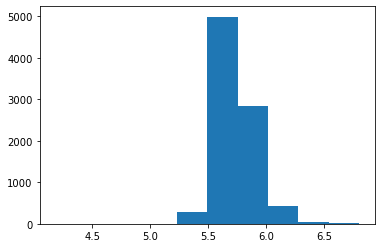

In [23]:
plt.hist(np.log10(df[pred]));

In [12]:
#X = dum_df
#y = df[pred]
y = np.log10(df[pred])

#Sparse Version
X = sparse_df


#### Train Test Split

In [13]:
train_test_tuple = X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [14]:
kf = 5 # KFold(n_splits=5, shuffle=True, random_state=10)

#### Standardisation

In [16]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [15]:
X_train = scipy.sparse.csr_matrix(X_train)
X_test = scipy.sparse.csr_matrix(X_test)

#### Creating a Model Scoring Function

In [16]:
def model_scorer(model, X_tr, X_ts, y_tr, y_ts):
    """Convenience function to print model scores and return """
    train_score = model.score(X_tr, y_tr)
    print('Train score:', train_score)
    
    cv = cross_val_score(model, X_tr, y_tr, cv=kf)
    print('CV scores:', cv)
    print('CV standard deviation:', cv.std() )
    print('Mean CV score:', cv.mean())
    
    test_score = model.score(X_ts, y_ts)
    print('Test score:', model.score(X_ts, y_ts))
     
    return {"train_score":train_score,
            "cv_scores":cv,
            "test_score":test_score}

#### Linear Regression - Good Score

In [17]:
lin_model_1 = LinearRegression()
lin_model_1.fit(X_train, y_train)


LinearRegression()

In [18]:
model_scorer(lin_model_1, X_train, X_test, y_train, y_test);

Train score: 0.9486219562146239
CV scores: [0.63989661 0.63476043 0.66439136 0.67582051 0.63706936]
CV standard deviation: 0.01658061031791857
Mean CV score: 0.6503876529547468
Test score: 0.6936267693759562


#### Decision Tree - Good Score

In [19]:
dt_model_1 = DecisionTreeRegressor()
dt_model_1.fit(X_train, y_train)

DecisionTreeRegressor()

In [20]:
model_scorer(dt_model_1, *train_test_tuple);

Train score: 0.9965177305064093
CV scores: [0.63879308 0.57656139 0.68146211 0.61780061 0.65790529]
CV standard deviation: 0.035797850429722264
Mean CV score: 0.6345044968648715
Test score: 0.6937382514544388


#### Random Forest - Best Mean CV Score

In [21]:
rf_model_1 = RandomForestRegressor()
rf_model_1.fit(X_train, y_train.values.flatten())

RandomForestRegressor()

In [22]:
model_scorer(rf_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

Train score: 0.9588468964328809
CV scores: [0.66527731 0.65713091 0.73060967 0.70194721 0.72099085]
CV standard deviation: 0.029356975840040517
Mean CV score: 0.6951911924788718
Test score: 0.7439200648918441


##### GridSearching Random Forest

In [ ]:
params = {'n_estimators': [100, 500, 700, 1000],
          'max_depth': [None, 1, 2, 3],
          'min_samples_split': [1, 2, 3]
         } 

GridSearchCV(RandomForestRegressor(),
             param_grid=params,
             n_jobs=2,
             cv = 3,
             verbose=2
            )


### Modellling with Regularisation

In [25]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet

#### Ridge

We close in on the best alpha by testing a wide range of alphas and then choosing the best range and then looking at it with ever more granularity. Here this is seen by iterating RidgeCV multiple times

In [26]:
np.logspace(-10,10,11)

array([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04,
       1.e+06, 1.e+08, 1.e+10])

In [27]:
ridge_cv_1 = RidgeCV(alphas=np.logspace(-10,10,11))
ridge_cv_1.fit(X_train,y_train)

RidgeCV(alphas=array([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04,
       1.e+06, 1.e+08, 1.e+10]))

In [28]:
ridge_cv_1.alpha_

1.0

In [29]:
ridge_cv_2 = RidgeCV(alphas=np.logspace(-2,2,11))
ridge_cv_2.fit(X_train,y_train)

RidgeCV(alphas=array([1.00000000e-02, 2.51188643e-02, 6.30957344e-02, 1.58489319e-01,
       3.98107171e-01, 1.00000000e+00, 2.51188643e+00, 6.30957344e+00,
       1.58489319e+01, 3.98107171e+01, 1.00000000e+02]))

In [30]:
ridge_cv_2.alpha_

0.3981071705534973

In [31]:
ridge_cv_3 = RidgeCV(alphas=np.linspace(1.58489319e-01,1.00000000e+00, 21))
ridge_cv_3.fit(X_train,y_train)

RidgeCV(alphas=array([0.15848932, 0.20056485, 0.24264039, 0.28471592, 0.32679146,
       0.36886699, 0.41094252, 0.45301806, 0.49509359, 0.53716913,
       0.57924466, 0.62132019, 0.66339573, 0.70547126, 0.7475468 ,
       0.78962233, 0.83169786, 0.8737734 , 0.91584893, 0.95792447,
       1.        ]))

In [32]:
ridge_cv_3.alpha_

0.53716912545

In [33]:
ridge_cv_4 = RidgeCV(alphas=np.linspace(0.36886699,0.41094252, 21))
ridge_cv_4.fit(X_train,y_train)

RidgeCV(alphas=array([0.36886699, 0.37097077, 0.37307454, 0.37517832, 0.3772821 ,
       0.37938587, 0.38148965, 0.38359343, 0.3856972 , 0.38780098,
       0.38990475, 0.39200853, 0.39411231, 0.39621608, 0.39831986,
       0.40042364, 0.40252741, 0.40463119, 0.40673497, 0.40883874,
       0.41094252]))

In [34]:
ridge_cv_4.alpha_

0.41094252

In [35]:
ridge_alpha_1 = ridge_cv_1.alpha_
ridge_model_1 = Ridge(alpha=ridge_alpha_1)
ridge_model_1.fit(X_train, y_train)

Ridge()

In [36]:
model_scorer(ridge_model_1, *train_test_tuple);

Train score: 0.862699754803717
CV scores: [0.71205972 0.61341902 0.64652237 0.51683975 0.73460569]
CV standard deviation: 0.07739564368765865
Mean CV score: 0.6446893110957813
Test score: 0.7503280521083806


In [37]:
ridge_model_1.alpha

1.0

In [38]:
ridge_alpha_2 = ridge_cv_2.alpha_
ridge_model_2 = Ridge(alpha=ridge_alpha_2)
ridge_model_2.fit(X_train, y_train)

Ridge(alpha=0.3981071705534973)

In [39]:
model_scorer(ridge_model_2, *train_test_tuple);

Train score: 0.9070732966702937
CV scores: [0.74941068 0.54932394 0.68303296 0.48088599 0.72555318]
CV standard deviation: 0.10454996601301066
Mean CV score: 0.6376413508764801
Test score: 0.7816072609257675


In [40]:
ridge_model_2.alpha

0.3981071705534973

In [41]:
ridge_alpha_3 = ridge_cv_3.alpha_
ridge_model_3 = Ridge(alpha=ridge_alpha_3)
ridge_model_3.fit(X_train, y_train)

Ridge(alpha=0.53716912545)

In [42]:
model_scorer(ridge_model_3, *train_test_tuple);

Train score: 0.8969969638114007
CV scores: [0.74146163 0.57206664 0.67496349 0.49312269 0.73081401]
CV standard deviation: 0.09583431941461333
Mean CV score: 0.6424856947459963
Test score: 0.775036045432567


#### Lasso - Good Score

In [43]:
lasso_cv_1 = LassoCV()
lasso_cv_1.fit(X_train, y_train.values.flatten())


LassoCV()

In [44]:
lasso_alpha = lasso_cv_1.alpha_
lasso_model_1 = Lasso(alpha=lasso_alpha)
lasso_model_1.fit(X_train, y_train.values.flatten())

Lasso(alpha=156.88928517173684)

In [45]:
model_scorer(lasso_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

Train score: 0.7385836668363523
CV scores: [0.73825834 0.48914349 0.65151387 0.49803754 0.71203306]
CV standard deviation: 0.10528271664818988
Mean CV score: 0.6177972585128659
Test score: 0.7310848756785298


#### ElasticNet

In [ ]:
alpha_range = np.logspace(-10,10,21)
l1_range = [.1, .5, .7, .9, .95, .99, 1]

elasticnet_cv_1 = ElasticNetCV(l1_ratio= l1_range,
                               alphas=alpha_range,
                               cv=3,
                               random_state=1,
                               n_jobs=2,
                               max_iter=100000
                              )
elasticnet_cv_1.fit(X_train,y_train.values.flatten())

In [ ]:
elasticnet_cv_1.l1_ratio_

In [ ]:
elasticnet_cv_1.alpha_

In [ ]:
elasticnet_alpha = elasticnet_cv_1.alpha_
elasticnet_l1 = elasticnet_cv_1.l1_ratio_
elasticnet_model_1 = ElasticNet(alpha=elasticnet_alpha, l1_ratio=elasticnet_l1)
elasticnet_model_1.fit(X_train, y_train.values.flatten())


In [ ]:
model_scorer(elasticnet_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

### BOOSTING

In [51]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor

#### AdaBoost

In [52]:
base_estimator = DecisionTreeRegressor()
ada_model_1 = AdaBoostRegressor(base_estimator=base_estimator,
                          n_estimators=100,
                          random_state=1)
ada_model_1.fit(X_train, y_train.values.flatten())


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100,
                  random_state=1)

In [53]:
model_scorer(ada_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

Train score: 0.990808945118217
CV scores: [0.60227246 0.48239121 0.58253535 0.53850878 0.77246815]
CV standard deviation: 0.09754299583445931
Mean CV score: 0.595635189296827
Test score: 0.789133450773172


#### Gradient Boost

In [54]:
gradientBoost_model_1 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=1)

gradientBoost_model_1.fit(X_train, y_train.values.flatten())


GradientBoostingRegressor(random_state=1)

In [55]:
model_scorer(gradientBoost_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten())

Train score: 0.8061598107384746
CV scores: [0.71926422 0.63115217 0.56896528 0.56968125 0.72771892]
CV standard deviation: 0.0692676559330288
Mean CV score: 0.6433563683091353
Test score: 0.7649969284157461


{'train_score': 0.8061598107384746,
 'cv_scores': array([0.71926422, 0.63115217, 0.56896528, 0.56968125, 0.72771892]),
 'test_score': 0.7649969284157461}

# SCIPY MODELLING?

Statsmodels do not work with sparse matrices so I will not be implementing this for the fully dummified postcode model

# COEFFICIENT ANALYSIS

In [61]:
# collect the model coefficients in a dataframe
lin_model_1_coefs = pd.DataFrame(lin_model_1.coef_.flatten(), index=dum_df.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
lin_model_1_coefs['coef_abs'] = lin_model_1_coefs.coefficients.abs()
#lin_model_1_coefs.sort_values('coef_abs', ascending=False).head(20)

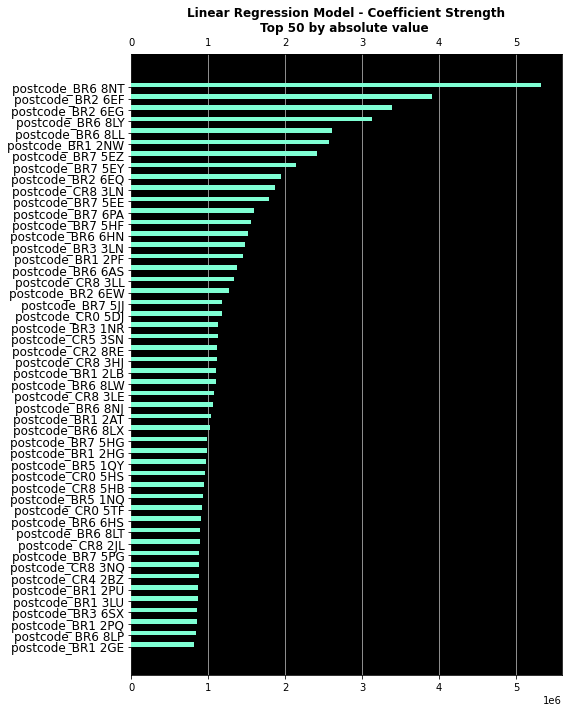

In [62]:
# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize=(8,10))
n_values_to_display = 50
plt_x = lin_model_1_coefs['coef_abs'].sort_values( ascending=False)[:n_values_to_display][::-1]
plt_y = lin_model_1_coefs[['coef_abs']].sort_values('coef_abs', ascending=False)[:n_values_to_display].index[::-1]

ax.barh(y=plt_y, width=plt_x, height=0.4, color='aquamarine', align='edge', zorder=3)
plt.yticks(fontsize=12) #fontdict={"fontsize":10})
#lin_model_1_coefs['coef_abs'].sort_values(ascending=False)[:20].plot(kind='barh', figsize=(10,20), color='purple')
ax.set_title(f"Linear Regression Model - Coefficient Strength\nTop {n_values_to_display} by absolute value ", fontweight='bold')#fontdict={'fontweight':"b"})

ax.set_facecolor('black')
ax.grid(axis='x', zorder=0)
ax.tick_params(labeltop=True)
plt.tight_layout();

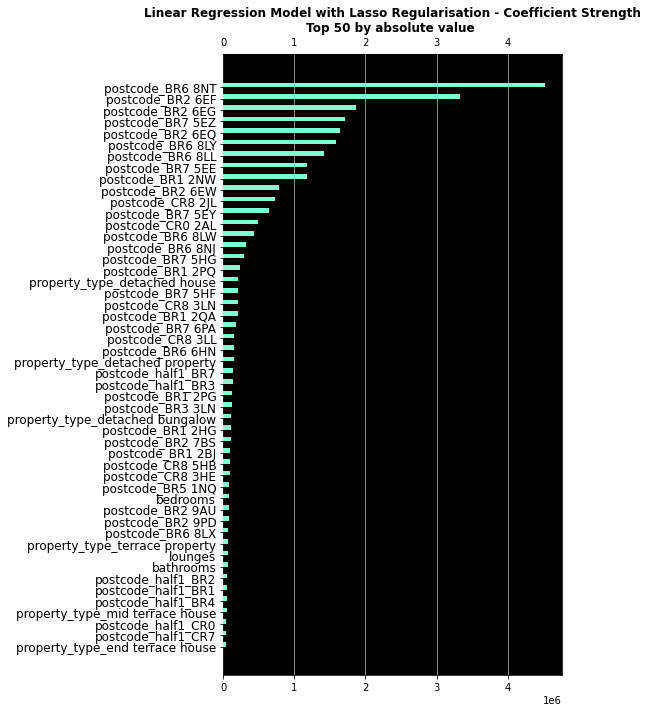

In [72]:
# collect the model coefficients in a dataframe
lasso_model_1_coefs = pd.DataFrame(lasso_model_1.coef_.flatten(), index=dum_df.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
lasso_model_1_coefs['coef_abs'] = lasso_model_1_coefs.coefficients.abs()
#lasso_model_1_coefs.sort_values('coef_abs', ascending=False).head(20)


# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize=(8,10))
n_values_to_display = 50
plt_x = lasso_model_1_coefs['coef_abs'].sort_values( ascending=False)[:n_values_to_display][::-1]
plt_y = lasso_model_1_coefs[['coef_abs']].sort_values('coef_abs', ascending=False)[:n_values_to_display].index[::-1]

ax.barh(y=plt_y, width=plt_x, height=0.4, color='aquamarine', align='edge', zorder=3)
plt.yticks(fontsize=12) #fontdict={"fontsize":10})
#lasso_model_1_coefs['coef_abs'].sort_values(ascending=False)[:20].plot(kind='barh', figsize=(10,20), color='purple')
ax.set_title(f"Linear Regression Model with Lasso Regularisation - Coefficient Strength\nTop {n_values_to_display} by absolute value ", fontweight='bold')#fontdict={'fontweight':"b"})

ax.set_facecolor('black')
ax.grid(axis='x', zorder=0)
ax.tick_params(labeltop=True)
plt.tight_layout();

### Visually testing predictions


In [175]:
y_test.iloc[25]

last_sold_price_gbp    532500.0
Name: 70352, dtype: float64

In [176]:
lin_model_1.predict(X_test[25])

array([[573118.31715066]])

In [177]:
rf_model_1.predict(X_test[25])

array([548880.])

In [178]:
dt_model_1.predict(X_test[25])

array([575000.])

# CONCLUSIONS


The best score achieved was using the Random Forest Regressor model with an R2 score of 0.7605. This means we have captured 76% of the predictive power with regards to true value of properties in the given areas of London using our best model. 

That said across models, the mean cv scores were significantly lower than the test scores and often had a wider spread. This may speak to a number of issues in the model. 
- The dataset may not be large enough to support the folds used (5)


The coefficients which had the largest affect on our score after Lasso Regularization were:
- Bedrooms
- Bathrooms
- Certain individual postcodes

One issue with the model may be the large number of dummified postcodes. As our dataset is relatively small individual postcodes have fewer and fewer unique properties. This means our full-postcode feature is acting almost like a uid value. That being said the test scores do indicate that we are not overfitting the model and that bias is kept relatively low




# NEXT STEPS - IMPROVING THE MODEL AND BEYOND


Our model would ideally be improved in a number of ways. 

Next goals of the model are to scrape all available properties in London (circa 3.5 Million). This will hopefully yield a much more general model of London property prices and allow the ultimate goal of the project which is to use the historical price model to predict whether particular properties listed on Zoopla are undervalued or not thereby identifying investment opportunities.